In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
#import config
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pdb
import os 
import sys

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

from collections import defaultdict
%matplotlib inline

outputdir = "C:\\Files\\UM\\ND\\SFN"
preprocessingdir = os.path.join("C:\\Files\\UM\\ND\\SFN","preprocessing_092024_no7822nofalcon")
characterizationdir = outputdir

def get_good_days():
    # review_results = pd.read_csv(config.reviewpath)
    # # filter out bad days
    # good_days = review_results.loc[review_results['Status'] == 'good']

    # #create histogram for current version (fewer days I guess?)
    # dates = good_days['Date'].to_numpy()

    filenames = [f for f in os.listdir(preprocessingdir) if not f.startswith('.')] #in case there are any hidden files
    filenames.remove('bad_days.txt')
    filenames.sort()
    dates = [file[0:10] for file in filenames]
    return dates

dates =  get_good_days()

In [2]:
def adjustfeats(X, Y, lag=0, hist=0, fillb4=None, out2d=False):
    '''
    This function takes in neural data X and behavior Y and returns two "adjusted" neural data and behavior matrices
    based on the optional params. Specifically the amount of lag between neural data and behavior can be set in units
    and the number of historical bins of neural data can be set. (BASED ON CODE BY SAM NASON)
    Inputs:
        - X (ndarray):
            The neural data, which should be [t, neu] in size, where t is the numebr of smaples and neu is the number
            of neurons.
        - y (ndarray):
            The behavioral data, which should be [t, dim] in size, where t is the number of samples and dim is the
            number of states.
        - lag (int, optional):
            Defaults to 0. The number of bins to lag the neural data relative to the behavioral data. For example,
            adjustFeats(X,Y, lag=1) will return X[0:-1] for adjX and Y[1:] for adjY.
        - hist (int, optional):
            Default 0. The number of bins to append to each sample of neural data from the previous 'hist' bins.
        - fillb4 (ndarray or scalar, optional):
            Default None, disabled. This fills previous neural data with values before the experiment began. A single
            scalar wil fill all previous neural data with that value. Otherwise, a [1,neu] ndarray equal to the first
            dimension of X (# of neurons) should represent the value to fill for each channel.
        - out2d (bool, optional):
            if history is added, will return the adjusted matrices either in 2d or 3d form (2d has the history appended
            as extra columns, 3d has history as a third dimension. For example, out2d true returns a sample as:
            [1, neu*hist+1] whereas out2d false returns: [1, neu, hist+1]. Default False
    Outputs:
        - adjX (ndarray):
            The adjusted neural data
        - adjY (ndarray):
            The adjusted behavioral data
    '''
    nNeu = X.shape[1]
    if fillb4 is not None:
        if isinstance(fillb4, np.ndarray):
            Xadd = np.tile(fillb4, hist)
            Yadd = np.zeros((hist, Y.shape[1]))
        else:
            Xadd = np.ones((hist, nNeu))*fillb4
            Yadd = np.zeros((hist, Y.shape[1]))
        X = np.concatenate((Xadd, X))
        Y = np.concatenate((Yadd, Y))

    #reshape data to include historical bins
    adjX = np.zeros((X.shape[0]-hist, nNeu, hist+1))
    for h in range(hist+1):
        adjX[:,:,h] = X[h:X.shape[0]-hist+h,:]
    adjY = Y[hist:,:]

    if lag != 0:
        adjX = adjX[0:-lag,:,:]
        adjY = adjY[lag:,:]

    if out2d:
        #NOTE: History will be succesive to each column (ie with history 5, columns 0-5 will be channel 1, 6-10
        # channel 2, etc..
        adjX = adjX.reshape(adjX.shape[0],-1)

    return adjX, adjY

In [3]:
def dataPrep(feats, hist, numChans=96):
    '''
    Get test and training data splits from a single session - also prep 2D and 3D versions

    '''
    TrialIndex = feats['trial_index']
    
    if len(TrialIndex) > 300:
        test_len = np.min((len(TrialIndex)-1, 399))

        # neural_training = feats['NeuralFeature'][:TrialIndex[300]]
        # neural_testing = feats['NeuralFeature'][TrialIndex[300]:TrialIndex[test_len]]

        # finger_training = feats['FingerAnglesTIMRL'][:TrialIndex[300]]
        # finger_testing = feats['FingerAnglesTIMRL'][TrialIndex[300]:TrialIndex[test_len]]

        neural_training = feats['sbp'][:TrialIndex[300]]
        neural_testing = feats['sbp'][TrialIndex[300]:TrialIndex[test_len]]

        finger_training = feats['finger_kinematics'][:TrialIndex[300]]
        finger_testing = feats['finger_kinematics'][TrialIndex[300]:TrialIndex[test_len]]

    else:
        pdb.set_trace()
        raise Exception('not enough trials')

        
    neural_training, finger_training = adjustfeats(neural_training, finger_training, hist = hist, out2d = True)
    neural_testing, finger_testing = adjustfeats(neural_testing, finger_testing, hist = hist, out2d = True)

    neural_testing = np.concatenate((neural_testing, np.ones((len(neural_testing), 1))), axis=1) # add a column of ones for RR
    neural_training = np.concatenate((neural_training, np.ones((len(neural_training), 1))), axis=1) # add a column of ones for RR

    return neural_training, neural_testing, finger_training, finger_testing

In [4]:
# perform sklearn ridge regression on each day and evaluate performance on all other days, store performance with relative day count in pandas dataframe

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def evaluate_model(model, d,ds):
    rs = np.zeros((1, 4))
    relative_days = []
    for date in filter(lambda x: x != d, ds):
        file = os.path.join(preprocessingdir, f'{date}_preprocess.pkl')
        relative_days.append(ds.index(d) - ds.index(date))

        with open(file, 'rb') as f:
            data_CO, data_RD = pickle.load(f)

        if data_CO and data_RD:
            neural_train, neural_test, finger_train, finger_test = dataPrep(data_CO, 20)
            reg = model
            reg.fit(neural_train, finger_train)
            rr_prediction = reg.predict(neural_test)
            rs_co = np.array([pearsonr(finger_test, rr_prediction).statistic]).reshape(1, 4)

            neural_train, neural_test, finger_train, finger_test = dataPrep(data_RD, 20)
            reg = model
            reg.fit(neural_train, finger_train)
            rr_prediction = reg.predict(neural_test)
            rs = np.concatenate((rs, (np.array([pearsonr(finger_test, rr_prediction).statistic]).reshape(1, 4) + rs_co) / 2), axis=0)

        elif data_CO:
            neural_train, neural_test, finger_train, finger_test = dataPrep(data_CO, 20)
            reg = model
            reg.fit(neural_train, finger_train)
            rr_prediction = reg.predict(neural_test)
            rs = np.concatenate((rs, np.array([pearsonr(finger_test, rr_prediction).statistic]).reshape(1, 4)), axis=0)

        elif data_RD:
            neural_train, neural_test, finger_train, finger_test = dataPrep(data_RD, 20)
            reg = model
            reg.fit(neural_train, finger_train)
            rr_prediction = reg.predict(neural_test)
            rs = np.concatenate((rs, np.array([pearsonr(finger_test, rr_prediction).statistic]).reshape(1, 4)), axis=0)


    performance_df = pd.DataFrame(rs[1:], columns=['IDX pos', 'MRS pos', 'IDX vel', 'MRS vel'])
    performance_df['RelativeDay'] = relative_days
    performance_df['Date'] = d

    return performance_df

# get 10 days from good days just for testing
seldates = dates[::-1][::max(1, len(dates)//20)][:20]


#initialize performance dataframe
performance_df = pd.DataFrame(columns=['IDX pos', 'MRS pos', 'IDX vel', 'MRS vel', 'RelativeDay', 'Date'])
for date in seldates:
    file = os.path.join(preprocessingdir,f'{date}_preprocess.pkl')
    sys.stdout.write(f"\r Date Processing: {date}")
    sys.stdout.flush()
    with open(file, 'rb') as f:
        data_CO, data_RD = pickle.load(f)
    
    if data_CO:
        neural_train, neural_test, finger_train, finger_test = dataPrep(data_CO,4)
        reg = linear_model.Ridge(alpha = 0.001,fit_intercept=False)
        reg.fit(neural_train, finger_train)

        performance = evaluate_model(reg,date,dates)

        
    if data_RD:
        neural_train, neural_test, finger_train, finger_test = dataPrep(data_RD,4)
        reg = linear_model.Ridge(alpha = 0.001,fit_intercept=False)
        reg.fit(neural_train, finger_train)

        performance = evaluate_model(reg,date,dates)


    if data_CO and data_RD:
        neural_train_CO, neural_test_CO, finger_train_CO, finger_test_CO = dataPrep(data_CO,4)
        neural_train_RD, neural_test_RD, finger_train_RD, finger_test_RD = dataPrep(data_RD,4)
        neural_train = np.concatenate((neural_train_CO, neural_train_RD), axis=0)
        neural_test = np.concatenate((neural_test_CO, neural_test_RD), axis=0)
        finger_train = np.concatenate((finger_train_CO, finger_train_RD), axis=0)
        finger_test = np.concatenate((finger_test_CO, finger_test_RD), axis=0)

        reg = linear_model.Ridge(alpha = 0.001,fit_intercept=False)
        reg.fit(neural_train, finger_train)

        performance = evaluate_model(reg,date,dates)

    # add back performance dataframes with additional date column for the date model is trained on
    performance_df = pd.concat([performance_df, performance], ignore_index=True)
#save to csv
performance_df.to_csv(os.path.join(characterizationdir, 'ridge_performance_relative_days.csv'), index=False)


 Date Processing: 2023-04-25

C:\Users\chang\AppData\Local\Temp\ipykernel_16416\156493002.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, performance], ignore_index=True)


 Date Processing: 2020-08-04

In [8]:
print(performance_df)

       IDX pos   MRS pos   IDX vel   MRS vel RelativeDay        Date
0     0.751713  0.808313  0.560013  0.487354         384  2024-02-05
1     0.680362  0.741821  0.469344  0.546307         383  2024-02-05
2     0.534130  0.742157  0.522103  0.485039         382  2024-02-05
3     0.649034  0.747472  0.474970  0.531639         381  2024-02-05
4     0.634429  0.722857  0.501715  0.500371         380  2024-02-05
...        ...       ...       ...       ...         ...         ...
7675  0.465955  0.627405  0.461304  0.414279        -357  2020-08-04
7676  0.368764  0.543854  0.159386  0.340664        -358  2020-08-04
7677  0.330620  0.406749  0.106666  0.348697        -359  2020-08-04
7678  0.427434  0.535256  0.124749  0.214926        -360  2020-08-04
7679  0.337419  0.393491  0.142443  0.162723        -361  2020-08-04

[7680 rows x 6 columns]


In [9]:
average_metrics = performance_df.groupby('RelativeDay')[['IDX pos', 'MRS pos', 'IDX vel', 'MRS vel']].mean()
print(average_metrics)

              IDX pos   MRS pos   IDX vel   MRS vel
RelativeDay                                        
-361         0.337419  0.393491  0.142443  0.162723
-360         0.427434  0.535256  0.124749  0.214926
-359         0.330620  0.406749  0.106666  0.348697
-358         0.368764  0.543854  0.159386  0.340664
-357         0.465955  0.627405  0.461304  0.414279
...               ...       ...       ...       ...
 380         0.634429  0.722857  0.501715  0.500371
 381         0.649034  0.747472  0.474970  0.531639
 382         0.534130  0.742157  0.522103  0.485039
 383         0.680362  0.741821  0.469344  0.546307
 384         0.751713  0.808313  0.560013  0.487354

[745 rows x 4 columns]


In [12]:
average_metrics['Average'] = average_metrics.mean(axis=1)
print(average_metrics)

              IDX pos   MRS pos   IDX vel   MRS vel   Average
RelativeDay                                                  
-361         0.337419  0.393491  0.142443  0.162723  0.259019
-360         0.427434  0.535256  0.124749  0.214926  0.325591
-359         0.330620  0.406749  0.106666  0.348697  0.298183
-358         0.368764  0.543854  0.159386  0.340664  0.353167
-357         0.465955  0.627405  0.461304  0.414279  0.492236
...               ...       ...       ...       ...       ...
 380         0.634429  0.722857  0.501715  0.500371  0.589843
 381         0.649034  0.747472  0.474970  0.531639  0.600779
 382         0.534130  0.742157  0.522103  0.485039  0.570857
 383         0.680362  0.741821  0.469344  0.546307  0.609458
 384         0.751713  0.808313  0.560013  0.487354  0.651848

[745 rows x 5 columns]


C:\Users\chang\AppData\Local\Temp\ipykernel_16416\2253630152.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Metrics')


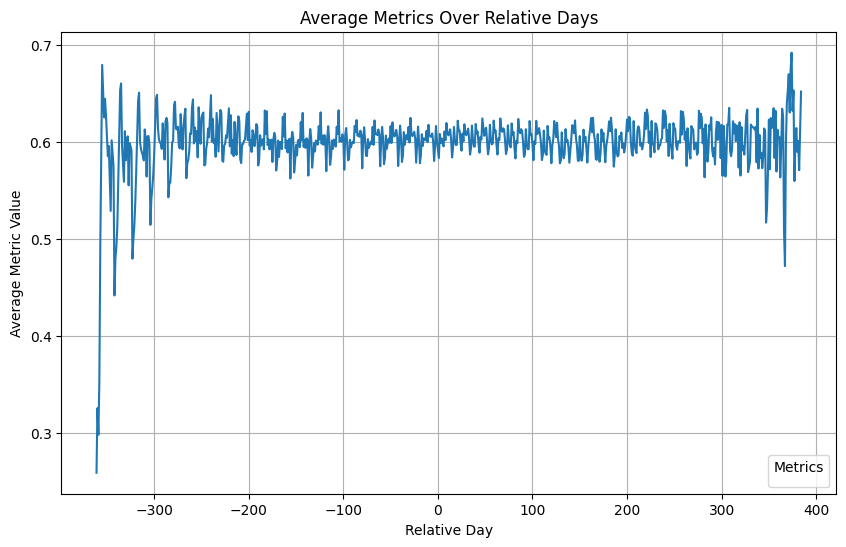

In [13]:
# Plot the average of average metrics relative days
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_metrics['Average'], dashes=False)
plt.title('Average Metrics Over Relative Days')
plt.xlabel('Relative Day')
plt.ylabel('Average Metric Value')
plt.legend(title='Metrics')
plt.grid()
plt.savefig(os.path.join(characterizationdir, 'average_metrics_relative_days.png'))